In [146]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from collections import namedtuple
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import linregress
import imageio

%matplotlib inline

# Optionally, tweak styles.
rc('animation', html='html5')
mpl.rc('figure',  figsize=(5, 10))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
import trackpy as tp

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import glob
from sxmreader import SXMReader

Params = namedtuple(
    'Params', 
    ['molecule_size', 
     'min_mass',
     'max_mass',
     'separation',
     'min_size',
     'max_ecc',
     'adaptive_stop',
     'search_range'])

voltage = np.arange(18, 23, 1, dtype=np.float32)
START = 447
SIZE = 3
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltage))]
params = [
     Params(molecule_size = 11,
        min_mass = 1,
        max_mass = 8,
        min_size = 0.5,
        max_ecc = 1,
        separation = 5,
        search_range = 40,
        adaptive_stop = 5) for i in range(len(voltage))
         ]
n_range = [i for i in sets]
N = [len(i) for i in sets]
SXM_PATH = [["electromigration_15/Image_{0:03}.sxm".format(i) for i in n_range[j]] for j in range(len(n_range))]

In [147]:
sets

[range(447, 451),
 range(450, 454),
 range(453, 457),
 range(456, 460),
 range(459, 463)]

In [148]:
voltage

array([18., 19., 20., 21., 22.], dtype=float32)

In [174]:
D_constants = []
indices = []
ems = []
idx = 0
#references = [7, 6, 8, 42, 45]
references = [None for _ in enumerate(voltage)]
for i, path in enumerate(SXM_PATH):
    frames = SXMReader(path)
    NM_PER_PIXEL = frames.meters_per_pixel / 1e-9
#     if i == 0:
#         frames[0] = frames[0][::-1]
    molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range = params[i]
    if separation:
        f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
    else:
        f = tp.batch(frames[:], molecule_size, minmass=min_mass)
    t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop, memory=3)    
    t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
    t2 = tp.filter_stubs(t, 1)
    if references[i]:
        d = tp.compute_drift(t2[t2.particle == references[i]])
    else:
        d = tp.compute_drift(t2)
    t3 = tp.subtract_drift(t2.copy(), d)
#     t3=t2
    displacements = tp.relate_frames(t3, 0, 1) * NM_PER_PIXEL
    for j in range(1, SIZE + 1):
        displacements = displacements.append(tp.relate_frames(t3, j, j + 1) * NM_PER_PIXEL, ignore_index=True)
    displacements = displacements.dropna()
    D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4) # r^2 = x^2 + y^2 = 2Dt + 2Dt
    idx=idx+1
D_constants = np.array(D_constants)

Frame 3: 6 trajectories present.


-576.1538409547996


Text(0.5, 1.0, 'Ed = -576.1538409547996 K')

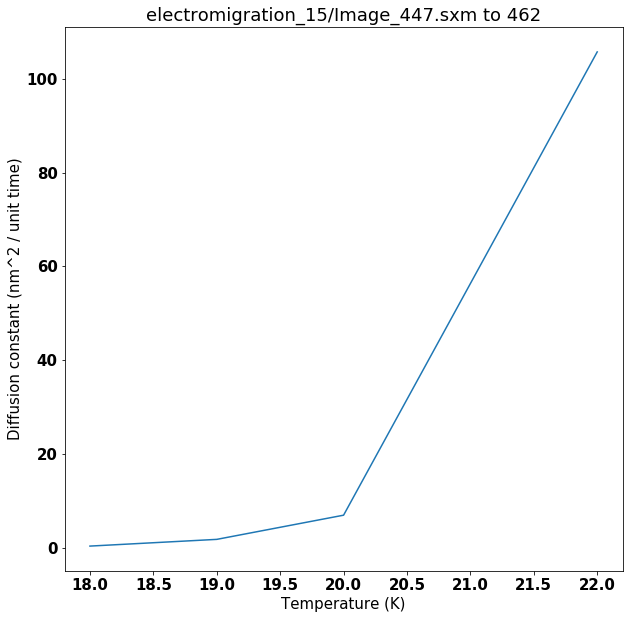

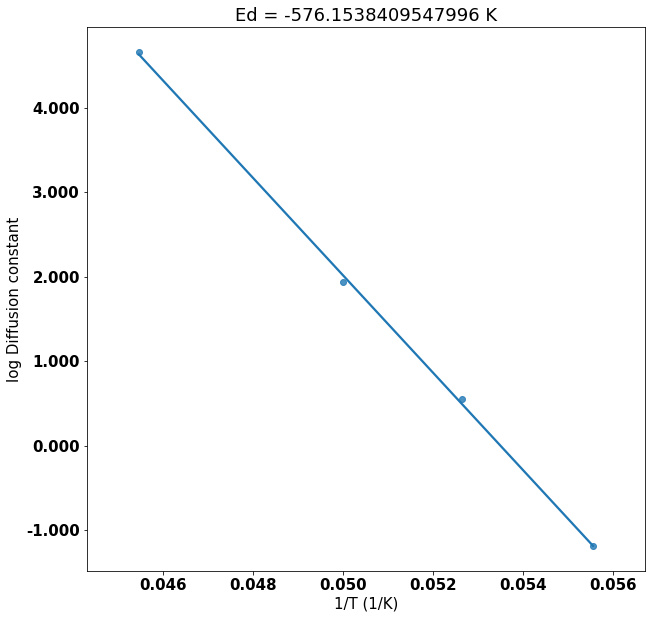

In [175]:
import seaborn as sns
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
from matplotlib.ticker import FormatStrFormatter
UNIT_TIME = "unit time"
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(np.arange(2.2,4.3,0.3), D_constants,'o-')
tmpv, D_constants = (list(t) for t in zip(*sorted(zip(voltage[:], D_constants))))
sns.lineplot(np.array(tmpv), D_constants, markers=True)
plt.title("{} to {}".format(SXM_PATH[0][0], sets[-1][-1]))
plt.xlabel('Temperature (K)')
plt.ylabel('Diffusion constant (nm^2 / {})'.format(UNIT_TIME))

fig, ax1 = plt.subplots(figsize=(10,10))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
nans = np.isnan(D_constants)
sns.regplot(np.reciprocal(tmpv), np.log(D_constants), 'o-', ci=None, ax=ax1)
result, _, _, _, _ = linregress(np.reciprocal(tmpv)[~nans], np.log(D_constants)[~nans])
print(result)
# upper = np.log(D_constants + D_constants / np.sqrt(np.array(Ns)[:,-1])) - np.log(D_constants)
# lower = np.log(D_constants) - np.log(D_constants - D_constants / np.sqrt(np.array(Ns)[:,-1]))
# yerr = np.stack((upper, lower))
# ax1.errorbar(np.reciprocal(tmpv), np.log(D_constants), yerr=yerr, fmt='none', color='b')
# ax1.set_yscale('log')
plt.xlabel('1/T (1/K)')
plt.ylabel('log Diffusion constant')
plt.title("Ed = {} K".format(result))

# fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(tmpv ,powers,'x-')
# plt.xlabel('V_SD (V)')
# plt.ylabel('power law')

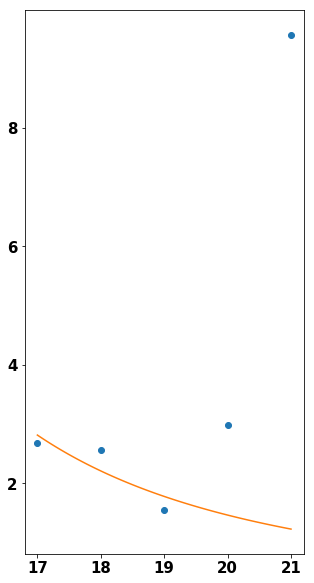

In [120]:
import scipy
def exponenial_func(x, a, b):
    return a * np.exp(-b / x )


popt, pcov = scipy.optimize.curve_fit(exponenial_func, tmpv[:3], D_constants[:3])

xx = np.linspace(voltage[0], voltage[-1], 100)
yy = exponenial_func(xx, *popt)

plt.plot(tmpv, np.array(D_constants), 'o')
plt.plot(xx, yy)

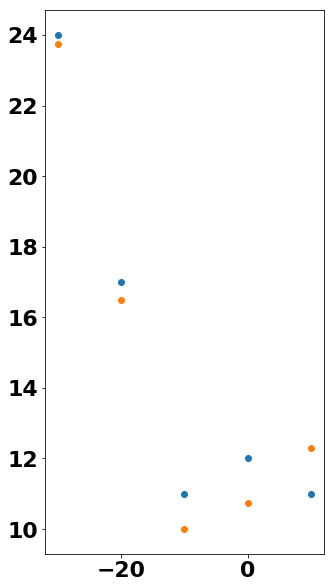

In [291]:
plt.plot([-30, -20, -10, 0, 10], [24, 17, 11, 12, 11], 'o')
vg = np.array([-30, -20, -10, 0, 10])
T_thresh = np.array([24, 17, 11, 12, 11])
E_diff = np.array([475, 330, 200, 215, 246])
plt.plot([-30, -20, -10, 0, 10], np.array([475, 330, 200, 215, 246]) / 20, 'o')

In [ ]:
"""
Parasite axis demo

The following code is an example of a parasite axis. It aims to show a user how
to plot multiple different values onto one single plot. Notice how in this
example, par1 and par2 are both calling twinx meaning both are tied directly to
the x-axis. From there, each of those two axis can behave separately from the
each other, meaning they can take on separate values from themselves as well as
the x-axis.
"""
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 0
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)
par1.axis["right"].toggle(all=False)

host.set_xlabel("Vg")
host.set_ylabel("E_diff")
par1.set_ylabel("T_thresh")
par2.set_ylabel("T_thresh")

p1, = host.plot(vg, E_diff, 'bo', label="E_diff")
p2, = par2.plot(vg, T_thresh, 'ro', label="T_thresh")
par2.set_ylim(10,25)
host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())

plt.draw()
plt.show()